<a href="https://colab.research.google.com/github/KimGriezmann/DeepLearning_BeTheLegend/blob/master/make_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **데이터 크롤링으로 가져오기**

In [ ]:
def data_crawling(year, num_top_batter=9):
  # Parameter
  # 원하는 연도 입력
  year = year
  # 데이터를 수집할 타자 중 타석 수 상위 명수
  num_top_batter = 9

  # Team List
  # 원하는 연도에 등록된 팀을 미리 넣어두어야함 (추가 가능)
  Team_2016 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2017 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2018 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2019 = ['NC','kt','LG','두산','키움','KIA','롯데','삼성','SK','한화']
  Team_2020 = ['NC','kt','LG','두산','키움','KIA','롯데','삼성','SK','한화']
  Team_2021 = ['kt','삼성','LG','SSG','NC','키움','두산','롯데','KIA','한화']

  # Team Dictionary
  # Team List를 딕셔너리에 넣음 (추가 가능)
  TeamDic = {'2016':Team_2016, '2017':Team_2017, '2018':Team_2018, '2019':Team_2019, '2020':Team_2020, '2021':Team_2021}

  ###############
  # BeautifulSoup

  import numpy as np
  import pandas as pd
  import requests
  from bs4 import BeautifulSoup
  from tqdm import tqdm

  # 데이터를 모을 dataframe 생성
  data = pd.DataFrame(columns=['name','날짜', '상대', '결과', '타순', 'P', '선발', '타수', '득점', '안타', '2타', '3타', '홈런', '루타', '타점', '도루', '도실',
                              '볼넷', '사구', '고4', '삼진', '병살', '희타', '희비', 'avg', '출루', '장타', 'OPS', '투구', 'avLI', 'RE24', 'WPA'])

  batter_data = pd.DataFrame(columns=['Team','name'])

  for Team in tqdm(TeamDic[str(year)]): # 선택한 연도의 팀을 하나씩 가져옴
    
    # 스탯티즈 시즌기록실 페이지에서 연도, 팀 선택하고, 타석순으로 정렬
    wp = requests.get("http://www.statiz.co.kr/stat.php?opt=0&sopt=0&re=0&ys=" + str(year) + "&ye=" + str(year) + "&se=0&te=" + Team + "&tm=&ty=0&qu=auto&po=0&as=&ae=&hi=&un=&pl=&da=1&o1=TPA&o2=TPA&de=1&lr=0&tr=&cv=&ml=1&sn=30&si=&cn=")
    soup = BeautifulSoup(wp.text, "html.parser")
    
    # 현재 팀의 타석 수 상위 num_top_batter 명
    tmp_batter_list = np.empty(num_top_batter,dtype=object)
    tmp_team = np.array([Team]*num_top_batter) # 타석 수 상위 타자 팀명 저장
    tmp_batter_list_href = np.empty(num_top_batter,dtype=object)
    tmp_batter_ps=0
    for batter in soup.find_all('tr')[2:11]:
      tmp_batter_list[tmp_batter_ps] = batter.find_all('td')[1].text # 타석 수 상위 타자 이름 저장
      tmp_batter_list_href[tmp_batter_ps] = batter.find_all('a')[0].attrs['href'] # 타석 수 상위 타자 주소 저장
      tmp_batter_ps+=1

    batter_data = pd.concat([batter_data, pd.DataFrame({'Team':tmp_team, 'name':tmp_batter_list})])

    # 타석 수 상위 타자들 중 한명씩 데이터를 모으는 과정
    for top_batter in range(num_top_batter):
      wp=requests.get("http://www.statiz.co.kr/"+tmp_batter_list_href[top_batter]) # 타자 주소로 접근
      soup=BeautifulSoup(wp.text, "html.parser")

      # 날짜별 데이터로 접근
      href_byDate = soup.select('body > div > div.content-wrapper > div > section.content > div > div:nth-of-type(1) > div > div.col-xs-12.col-sm-8.col-md-8.col-lg-12 > div > div.table-responsive.no-padding.box > table')[0].find_all('a')[3].attrs['href']
      wp=requests.get("http://www.statiz.co.kr/"+href_byDate)
      soup=BeautifulSoup(wp.text,"html.parser")

      # year : 원하는 연도로 접근
      href_byDate_year=soup.select('body > div.wrapper > div.content-wrapper > div > section.content > div > div:nth-of-type(2) > div > div:nth-of-type(2) > div')[0].find('a', text=str(year)).attrs['href']
      wp=requests.get("http://www.statiz.co.kr/"+href_byDate_year)
      soup=BeautifulSoup(wp.text,"html.parser")

      ## 데이터가 있는 페이지로 이동 완료
      ## 이제 실질적인 데이터를 모을 차례
      rawdata=soup.select('body > div > div.content-wrapper > div > section.content > div > div:nth-of-type(2) > div > div:nth-of-type(3) > div > div > table')[0]
      # rawdata : 전체 테이블

      # th를 제외한 순수한 경기 데이터 / th는 컬럼명 행이다.
      rawdata_not_th = rawdata.find_all('tr',{'class':['oddrow_stz0','evenrow_stz0']})

      # 행렬만들기
      rawdata_name = np.array([tmp_batter_list[top_batter]]*len(rawdata_not_th))
      rawdata_day = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_vs_team = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_result = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_bat_order = np.zeros(len(rawdata_not_th),dtype=np.int_)
      rawdata_position = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_start_memeber = np.zeros(len(rawdata_not_th), dtype=np.bool)
      rawdata_ab = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_score = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_2_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_3_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_homerun = np.zeros(len(rawdata_not_th), dtype=np.int_)
      # 영어명으로 변경 필요
      rawdata_루타 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_타점 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_도루 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_도실 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_볼넷 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_사구 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_고4 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_삼진 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_병살 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_희타 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rewdata_희비 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_avg = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_출루 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_장타 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_ops = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_투구 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_avLI = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_RE24 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_WPA = np.zeros(len(rawdata_not_th), dtype=np.float)

      for rawdata_not_th_tr_index in range(len(rawdata_not_th)):
        # 한 행 : rawdata_not_th_tr_index
        rawdata_not_th_td = [text for text in rawdata_not_th[rawdata_not_th_tr_index].stripped_strings]
        # 현재 행의 하나의 값 : rawdata_not_th_td[index]
        # 데이터 입력
        rawdata_day[rawdata_not_th_tr_index] = rawdata_not_th_td[1]
        rawdata_vs_team[rawdata_not_th_tr_index] = rawdata_not_th_td[2]
        rawdata_result[rawdata_not_th_tr_index] = rawdata_not_th_td[3]+" "+rawdata_not_th_td[4]
        rawdata_bat_order[rawdata_not_th_tr_index] = rawdata_not_th_td[5]
        rawdata_position[rawdata_not_th_tr_index] = rawdata_not_th_td[6]
        rawdata_start_memeber[rawdata_not_th_tr_index] = rawdata_not_th_td[7]
        rawdata_ab[rawdata_not_th_tr_index] = rawdata_not_th_td[8]
        rawdata_score[rawdata_not_th_tr_index] = rawdata_not_th_td[9]
        rawdata_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[10]
        rawdata_2_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[11]
        rawdata_3_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[12]
        rawdata_homerun[rawdata_not_th_tr_index] = rawdata_not_th_td[13]
        rawdata_루타[rawdata_not_th_tr_index] = rawdata_not_th_td[14]
        rawdata_타점[rawdata_not_th_tr_index] = rawdata_not_th_td[15]
        rawdata_도루[rawdata_not_th_tr_index] = rawdata_not_th_td[16]
        rawdata_도실[rawdata_not_th_tr_index] = rawdata_not_th_td[17]
        rawdata_볼넷[rawdata_not_th_tr_index] = rawdata_not_th_td[18]
        rawdata_사구[rawdata_not_th_tr_index] = rawdata_not_th_td[19]
        rawdata_고4[rawdata_not_th_tr_index] = rawdata_not_th_td[20]
        rawdata_삼진[rawdata_not_th_tr_index] = rawdata_not_th_td[21]
        rawdata_병살[rawdata_not_th_tr_index] = rawdata_not_th_td[22]
        rawdata_희타[rawdata_not_th_tr_index] = rawdata_not_th_td[23]
        rewdata_희비[rawdata_not_th_tr_index] = rawdata_not_th_td[24]
        rawdata_avg[rawdata_not_th_tr_index] = rawdata_not_th_td[25]
        rawdata_출루[rawdata_not_th_tr_index] = rawdata_not_th_td[26]
        rawdata_장타[rawdata_not_th_tr_index] = rawdata_not_th_td[27]
        rawdata_ops[rawdata_not_th_tr_index] = rawdata_not_th_td[28]
        rawdata_투구[rawdata_not_th_tr_index] = rawdata_not_th_td[29]
        rawdata_avLI[rawdata_not_th_tr_index] = rawdata_not_th_td[30]
        rawdata_RE24[rawdata_not_th_tr_index] = rawdata_not_th_td[31]
        rawdata_WPA[rawdata_not_th_tr_index] = rawdata_not_th_td[32]

      tmp_data = pd.DataFrame()
      # tmp_data는 각 선수마다 데이터를 모은 후 data에 머지하기 전에 존재
      tmp_data['name'] = rawdata_name
      tmp_data['day'] = rawdata_day
      tmp_data['vs_team'] = rawdata_vs_team
      tmp_data['결과'] = rawdata_result
      tmp_data['타순'] = rawdata_bat_order
      tmp_data['P'] = rawdata_position
      tmp_data['선발'] = rawdata_start_memeber
      tmp_data['ab'] = rawdata_ab
      tmp_data['득점'] = rawdata_score
      tmp_data['hit'] = rawdata_hit
      tmp_data['2타'] = rawdata_2_hit
      tmp_data['3타'] = rawdata_3_hit
      tmp_data['홈런'] = rawdata_homerun
      tmp_data['루타'] = rawdata_루타
      tmp_data['타점'] = rawdata_타점
      tmp_data['도루'] = rawdata_도루
      tmp_data['도실'] = rawdata_도실
      tmp_data['볼넷'] = rawdata_볼넷
      tmp_data['사구'] = rawdata_사구
      tmp_data['고4'] = rawdata_고4
      tmp_data['삼진'] = rawdata_삼진
      tmp_data['병살'] = rawdata_병살
      tmp_data['희타'] = rawdata_희타
      tmp_data['희비'] = rewdata_희비
      tmp_data['avg'] = rawdata_avg
      tmp_data['출루'] = rawdata_출루
      tmp_data['장타'] = rawdata_장타
      tmp_data['OPS'] = rawdata_ops
      tmp_data['투구'] = rawdata_투구
      tmp_data['avLI'] = rawdata_avLI
      tmp_data['RE24'] = rawdata_RE24
      tmp_data['WPA'] = rawdata_WPA

      # 데이터 쌓기
      data = pd.concat([data,tmp_data])

  return data, batter_data


In [ ]:
# data_2018, batter_data_2018 = data_crawling(2018,9)
# data_2019, batter_data_2019 = data_crawling(2019,9)
# data_2020, batter_data_2020 = data_crawling(2020,9)
data_2021, batter_data_2021 = data_crawling(2021,9)

100%|██████████| 10/10 [07:27<00:00, 44.80s/it]


In [ ]:
data_2018.to_csv("data_2018.csv", encoding='euc-kr', index=False)
data_2019.to_csv("data_2019.csv", encoding='euc-kr', index=False)
data_2020.to_csv("data_2020.csv", encoding='euc-kr', index=False)
data_2021.to_csv("data_2021.csv", encoding='euc-kr', index=False)

batter_data_2018.to_csv("batter_data_2018.csv", encoding='euc-kr', index=False)
batter_data_2019.to_csv("batter_data_2019.csv", encoding='euc-kr', index=False)
batter_data_2020.to_csv("batter_data_2020.csv", encoding='euc-kr', index=False)
batter_data_2021.to_csv("batter_data_2021.csv", encoding='euc-kr', index=False)

In [2]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/data_2021.csv', encoding='euc-kr')
batter_data_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/batter_data_2021.csv', encoding='euc-kr')

### **날짜 형식 변경**

In [13]:
import pandas as pd
import numpy as numpy

# 날짜 데이터 값, 형식 변경
# 현재 : object 형식으로 "2018-04-04" 값으로 존재 (의미 : 4월 4일)
# 변경 : int 형식으로 20180404 으로 변경 (의미 : 2018년 4월 4일)

def day_to_int(data):
  data['day'] = pd.to_numeric(data['day'].str.replace("-",""))
  return data

In [10]:
data_2021 = day_to_int(data_2021)

### **더블헤더 처리**

In [39]:
# 더블헤더 처리
temp = np.zeros(len(data_2021))

# day, name이 같은 값이 있다는 것은 더블헤더 경기가 있다는것
# keep=False 옵션은 중복 값에 해당하는 튜플들을 모두 True로 리턴, 그 외 옵션 : 'first', 'last' 의 경우 둘 중 하나만 True
dup = data_2021.loc[:,['day','name']].duplicated(keep=False) 

for i in range(len(data_2021)):
  if dup[i]==False:
    temp[i]=0
  elif dup[i]==True:
    temp[i]=1

# 중복의 첫번째 행은 더블헤더 1차전
# 중복인 두번째 행이 더블헤더 2차전이다.
for i in range(1,len(temp)):
  if temp[i]==1 and temp[i-1]==1:
    temp[i]=2

data_2021['double']=temp

In [41]:
ex_data = data_2021.loc[:, ['name', 'day', 'double', 'vs', 'ab', 'hit']]

### **vs에서 @ 유무에 따라 home / away 구분하기**

In [42]:
def make_vs(data):
  data['vs_team'] = [s[1:] if s[0] == '@' else s for s in data['vs']] 

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe

  return result_Dataframe

In [43]:
ex_data2 = make_vs(ex_data)
ex_data2

,name,day,double,vs,vs_team,ab,hit
0,강백호,20210404,0.0,한화,한화,3,2
1,강백호,20210406,0.0,LG,LG,4,0
2,강백호,20210407,0.0,LG,LG,4,3
3,강백호,20210408,0.0,LG,LG,4,2
4,강백호,20210409,0.0,@삼성,삼성,5,3
...,...,...,...,...,...,...,...
5815,김민하,20210623,0.0,@삼성,삼성,3,1
5816,김민하,20210624,0.0,@삼성,삼성,4,0
5817,김민하,20210626,0.0,KT,KT,1,0
5818,김민하,20210709,0.0,@SSG,SSG,4,1


### **해당 경기의 안타 성공 결과(result) 도출**

In [44]:
def make_result(data):
  data['result'] = [0 if s == 0 else 1 for s in data['hit']] 

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe

  return result_Dataframe

In [45]:
ex_data3 = make_result(ex_data2)
ex_data3

,name,day,double,vs,vs_team,ab,hit,result
0,강백호,20210404,0.0,한화,한화,3,2,1
1,강백호,20210406,0.0,LG,LG,4,0,0
2,강백호,20210407,0.0,LG,LG,4,3,1
3,강백호,20210408,0.0,LG,LG,4,2,1
4,강백호,20210409,0.0,@삼성,삼성,5,3,1
...,...,...,...,...,...,...,...,...
5815,김민하,20210623,0.0,@삼성,삼성,3,1,1
5816,김민하,20210624,0.0,@삼성,삼성,4,0,0
5817,김민하,20210626,0.0,KT,KT,1,0,0
5818,김민하,20210709,0.0,@SSG,SSG,4,1,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


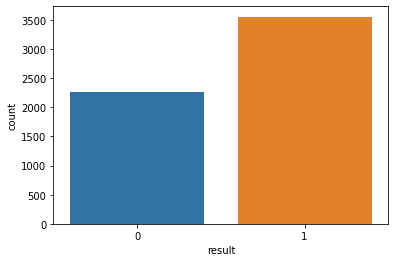

In [46]:
sns.countplot(ex_data3['result'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


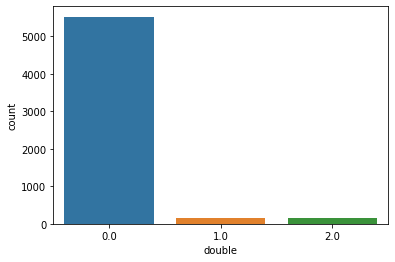

In [47]:
sns.countplot(ex_data3['double'])
plt.show()

### **home/away 구분하는 열 추가**

In [48]:
def make_home_away(data):
  data['home/away'] = ['away' if s[0] == '@' else 'home' for s in data['vs']]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe

  return result_Dataframe

In [49]:
ex_data4 = make_home_away(ex_data3)
ex_data4

,name,day,double,vs,vs_team,ab,hit,result,home/away
0,강백호,20210404,0.0,한화,한화,3,2,1,home
1,강백호,20210406,0.0,LG,LG,4,0,0,home
2,강백호,20210407,0.0,LG,LG,4,3,1,home
3,강백호,20210408,0.0,LG,LG,4,2,1,home
4,강백호,20210409,0.0,@삼성,삼성,5,3,1,away
...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,0.0,@삼성,삼성,3,1,1,away
5816,김민하,20210624,0.0,@삼성,삼성,4,0,0,away
5817,김민하,20210626,0.0,KT,KT,1,0,0,home
5818,김민하,20210709,0.0,@SSG,SSG,4,1,1,away


### **home/away별 타율 구하는 과정**

In [50]:
def make_home_away_slot(data):
  data['home_ab'] = [0 if s == 'home' else 0 for s, ab in zip(data['home/away'], data['ab'])]
  data['home_hit'] = [0 if s == 'home' else 0 for s, hit in zip(data['home/away'], data['hit'])]
  data['away_ab'] = [0 if s == 'away' else 0 for s, ab in zip(data['home/away'], data['ab'])]
  data['away_hit'] = [0 if s == 'away' else 0 for s, hit in zip(data['home/away'], data['hit'])]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['home_ab'] = data['home_ab']
  result_Dataframe['home_hit'] = data['home_hit']
  result_Dataframe['away_ab'] = data['away_ab']
  result_Dataframe['away_hit'] = data['away_hit']
  result_Dataframe

  return result_Dataframe  

In [51]:
ex_data5 = make_home_away_slot(ex_data4)
ex_data5

,name,day,double,vs,vs_team,ab,hit,home/away,home_ab,home_hit,away_ab,away_hit
0,강백호,20210404,0.0,한화,한화,3,2,home,0,0,0,0
1,강백호,20210406,0.0,LG,LG,4,0,home,0,0,0,0
2,강백호,20210407,0.0,LG,LG,4,3,home,0,0,0,0
3,강백호,20210408,0.0,LG,LG,4,2,home,0,0,0,0
4,강백호,20210409,0.0,@삼성,삼성,5,3,away,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,0.0,@삼성,삼성,3,1,away,0,0,0,0
5816,김민하,20210624,0.0,@삼성,삼성,4,0,away,0,0,0,0
5817,김민하,20210626,0.0,KT,KT,1,0,home,0,0,0,0
5818,김민하,20210709,0.0,@SSG,SSG,4,1,away,0,0,0,0


In [54]:
def make_home_away_ab_hit(data, batter):
  result_Dataframe = pd.DataFrame()
  for h in tqdm.tqdm(batter['name'].values): # 90명 타자 한명씩 접근
    hdata = data.loc[data['name']== h ]
    for i in range(0, len(hdata)-1):
      if hdata.iloc[i, 7] == 'home':
        hdata.iloc[i+1, 8] = hdata.iloc[i, 8] + hdata.iloc[i, 5]
        hdata.iloc[i+1, 10] = hdata.iloc[i, 10]
        hdata.iloc[i+1, 9] = hdata.iloc[i, 9] + hdata.iloc[i, 6]
        hdata.iloc[i+1, 11] = hdata.iloc[i, 11]
      else:
        hdata.iloc[i+1, 10] = hdata.iloc[i, 10] + hdata.iloc[i, 5]
        hdata.iloc[i+1, 8] = hdata.iloc[i, 8]
        hdata.iloc[i+1, 11] = hdata.iloc[i, 11] + hdata.iloc[i, 6]
        hdata.iloc[i+1, 9] = hdata.iloc[i, 9]
    result_Dataframe = pd.concat([result_Dataframe, hdata])

  return result_Dataframe


In [55]:
ex_data6 = make_home_away_ab_hit(ex_data5, batter_data_2021)
ex_data6

  0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
100%|██████████| 90/90 [00:09<00:00,  9.28it/s]


,name,day,double,vs,vs_team,ab,hit,home/away,home_ab,home_hit,away_ab,away_hit
0,강백호,20210404,0.0,한화,한화,3,2,home,0,0,0,0
1,강백호,20210406,0.0,LG,LG,4,0,home,3,2,0,0
2,강백호,20210407,0.0,LG,LG,4,3,home,7,2,0,0
3,강백호,20210408,0.0,LG,LG,4,2,home,11,5,0,0
4,강백호,20210409,0.0,@삼성,삼성,5,3,away,15,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,0.0,@삼성,삼성,3,1,away,47,15,46,5
5816,김민하,20210624,0.0,@삼성,삼성,4,0,away,47,15,49,6
5817,김민하,20210626,0.0,KT,KT,1,0,home,47,15,53,6
5818,김민하,20210709,0.0,@SSG,SSG,4,1,away,48,15,53,6


In [56]:
def make_home_away_avg(data):
  data['home/away_avg'] = np.where(data['home/away'] == 'home', round(data['home_hit']/data['home_ab'],3), round(data['away_hit'] / data['away_ab'],3))

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['home_ab'] = data['home_ab']
  result_Dataframe['home_hit'] = data['home_hit']
  result_Dataframe['away_ab'] = data['away_ab']
  result_Dataframe['away_hit'] = data['away_hit']
  result_Dataframe['home/away_avg'] = data['home/away_avg']
  result_Dataframe['home/away_avg'].fillna(0, inplace = True)
  result_Dataframe

  return result_Dataframe  

In [57]:
hw_data = make_home_away_avg(ex_data6)
hw_data

,name,day,double,vs,vs_team,ab,hit,home/away,home_ab,home_hit,away_ab,away_hit,home/away_avg
0,강백호,20210404,0.0,한화,한화,3,2,home,0,0,0,0,0.000
1,강백호,20210406,0.0,LG,LG,4,0,home,3,2,0,0,0.667
2,강백호,20210407,0.0,LG,LG,4,3,home,7,2,0,0,0.286
3,강백호,20210408,0.0,LG,LG,4,2,home,11,5,0,0,0.455
4,강백호,20210409,0.0,@삼성,삼성,5,3,away,15,7,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,0.0,@삼성,삼성,3,1,away,47,15,46,5,0.109
5816,김민하,20210624,0.0,@삼성,삼성,4,0,away,47,15,49,6,0.122
5817,김민하,20210626,0.0,KT,KT,1,0,home,47,15,53,6,0.319
5818,김민하,20210709,0.0,@SSG,SSG,4,1,away,48,15,53,6,0.113


### **상대 팀별 타율 구하기**

In [58]:
sort_data = ex_data3.sort_values(by=["vs_team", "name"])
sort_data 

,name,day,double,vs,vs_team,ab,hit,result,home/away
901,강민호,20210424,0.0,@KIA,KIA,4,2,1,away
902,강민호,20210425,0.0,@KIA,KIA,4,2,1,away
919,강민호,20210521,0.0,KIA,KIA,3,0,0,home
920,강민호,20210523,0.0,KIA,KIA,3,1,1,home
928,강민호,20210608,0.0,KIA,KIA,4,2,1,home
...,...,...,...,...,...,...,...,...,...
445,황재균,20210612,0.0,한화,한화,5,2,1,home
446,황재균,20210613,0.0,한화,한화,2,1,1,home
456,황재균,20210625,0.0,@한화,한화,2,0,0,away
457,황재균,20210626,0.0,@한화,한화,5,2,1,away


In [59]:
def make_vs_slot(data):
  data['vs_ab'] = [0 if s == 'home' else 0 for s in data['home/away']]
  data['vs_hit'] = [0 if s == 'home' else 0 for s in data['home/away']]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['vs_ab'] = data['vs_ab']
  result_Dataframe['vs_hit'] = data['vs_hit']
  result_Dataframe

  return result_Dataframe  

In [60]:
vs_data = make_vs_slot(sort_data)
vs_data

,name,day,double,vs,vs_team,ab,hit,result,home/away,vs_ab,vs_hit
901,강민호,20210424,0.0,@KIA,KIA,4,2,1,away,0,0
902,강민호,20210425,0.0,@KIA,KIA,4,2,1,away,0,0
919,강민호,20210521,0.0,KIA,KIA,3,0,0,home,0,0
920,강민호,20210523,0.0,KIA,KIA,3,1,1,home,0,0
928,강민호,20210608,0.0,KIA,KIA,4,2,1,home,0,0
...,...,...,...,...,...,...,...,...,...,...,...
445,황재균,20210612,0.0,한화,한화,5,2,1,home,0,0
446,황재균,20210613,0.0,한화,한화,2,1,1,home,0,0
456,황재균,20210625,0.0,@한화,한화,2,0,0,away,0,0
457,황재균,20210626,0.0,@한화,한화,5,2,1,away,0,0


In [61]:
def make_vs_ab_hit(data):
  result_Dataframe = pd.DataFrame()
  team = np.array(('KIA', 'KT', 'LG', 'SSG', 'NC', '롯데', '두산', '삼성', '키움', '한화', 'SK'))

  for t in tqdm.tqdm(team):
    vdata = data.loc[data['vs_team']== t]  
    for i in range(0, len(vdata)-1):
      if vdata.iloc[i]['name'] == vdata.iloc[i+1]['name']:
        vdata.iloc[i+1, 9] = vdata.iloc[i, 9] + vdata.iloc[i, 5] #vs_ab
        vdata.iloc[i+1, 10] = vdata.iloc[i, 10] + vdata.iloc[i, 6] #vs_hit
      else:
        vdata.iloc[i+1, 9] = 0
        vdata.iloc[i+1, 10] = 0

    result_Dataframe = pd.concat([result_Dataframe, vdata])

  return result_Dataframe

In [ ]:
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

In [67]:
vs_ab_hit_data = make_vs_ab_hit(vs_data)
vs_ab_hit_data

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


,name,day,double,vs,vs_team,ab,hit,result,home/away,vs_ab,vs_hit
901,강민호,20210424,0.0,@KIA,KIA,4,2,1,away,0,0
902,강민호,20210425,0.0,@KIA,KIA,4,2,1,away,4,2
919,강민호,20210521,0.0,KIA,KIA,3,0,0,home,8,4
920,강민호,20210523,0.0,KIA,KIA,3,1,1,home,11,4
928,강민호,20210608,0.0,KIA,KIA,4,2,1,home,14,5
...,...,...,...,...,...,...,...,...,...,...,...
445,황재균,20210612,0.0,한화,한화,5,2,1,home,9,2
446,황재균,20210613,0.0,한화,한화,2,1,1,home,14,4
456,황재균,20210625,0.0,@한화,한화,2,0,0,away,16,5
457,황재균,20210626,0.0,@한화,한화,5,2,1,away,18,5


In [74]:
def make_vs_avg(data):
  for i in range(0, len(data)+1):
    try:
      data['vs_avg'] = round(data['vs_hit']/data['vs_ab'], 3)
    except ZeroDivisionError:
      data['vs_avg'] = 0

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['vs_ab'] = data['vs_ab']
  result_Dataframe['vs_hit'] = data['vs_hit']
  result_Dataframe['vs_avg'] = data['vs_avg']
  result_Dataframe['vs_avg'].fillna(0, inplace = True)
  result_Dataframe

  return result_Dataframe  

In [75]:
final_vs_avg_data = make_vs_avg(vs_ab_hit_data)
final_vs_avg_data

,name,day,double,vs,vs_team,ab,hit,result,home/away,vs_ab,vs_hit,vs_avg
901,강민호,20210424,0.0,@KIA,KIA,4,2,1,away,0,0,0.000
902,강민호,20210425,0.0,@KIA,KIA,4,2,1,away,4,2,0.500
919,강민호,20210521,0.0,KIA,KIA,3,0,0,home,8,4,0.500
920,강민호,20210523,0.0,KIA,KIA,3,1,1,home,11,4,0.364
928,강민호,20210608,0.0,KIA,KIA,4,2,1,home,14,5,0.357
...,...,...,...,...,...,...,...,...,...,...,...,...
445,황재균,20210612,0.0,한화,한화,5,2,1,home,9,2,0.222
446,황재균,20210613,0.0,한화,한화,2,1,1,home,14,4,0.286
456,황재균,20210625,0.0,@한화,한화,2,0,0,away,16,5,0.312
457,황재균,20210626,0.0,@한화,한화,5,2,1,away,18,5,0.278


In [77]:
final_2021_data = pd.merge(data_2021, ex_data6, on = ['name', 'day', 'double'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, hw_data, on = ['name', 'day', 'double'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, final_vs_avg_data, on = ['name', 'day', 'double'], how = 'inner')
final_2021_data

,name,day,vs_x,result_x,bat_order,position,start_member,ab_x,score,hit_x,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double,vs_y,vs_team_x,ab_y,hit_y,home/away_x,home_ab_x,home_hit_x,away_ab_x,away_hit_x,home/away_avg_x,vs_x,vs_team_y,ab_x,hit_x,home/away_y,home_ab_y,home_hit_y,away_ab_y,away_hit_y,home/away_avg_y,vs_y,vs_team,ab_y,hit_y,result_y,home/away,vs_ab,vs_hit,vs_avg
0,강백호,20210404,한화,W 3:2,4,1B,True,3,0,2,0,0,0,2,0,2,0,1,0,0,0,0,0,0,0.667,NaN,0.667,1.417,16,1.14,0.89,0.122,0.0,한화,한화,3,2,home,0,0,0,0,NaN,한화,한화,3,2,home,0,0,0,0,0.000,한화,한화,3,2,1,home,0,0,0.000
1,강백호,20210406,LG,L 2:3,4,1B,True,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.286,NaN,0.286,0.661,14,2.07,-1.00,-0.183,0.0,LG,LG,4,0,home,3,2,0,0,0.667,LG,LG,4,0,home,3,2,0,0,0.667,LG,LG,4,0,0,home,0,0,0.000
2,강백호,20210407,LG,W 7:3,4,1B,True,4,0,3,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0.455,NaN,0.455,0.993,17,1.43,1.75,0.330,0.0,LG,LG,4,3,home,7,2,0,0,0.286,LG,LG,4,3,home,7,2,0,0,0.286,LG,LG,4,3,1,home,4,0,0.000
3,강백호,20210408,LG,L 3:7,4,1B,True,4,0,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0.467,NaN,0.467,0.996,17,0.89,-0.76,-0.102,0.0,LG,LG,4,2,home,11,5,0,0,0.455,LG,LG,4,2,home,11,5,0,0,0.455,LG,LG,4,2,1,home,8,3,0.375
4,강백호,20210409,@삼성,L 5:7,4,1B,True,5,0,3,0,1,0,5,3,0,0,0,0,0,1,1,0,0,0.500,NaN,0.600,1.145,21,0.94,1.88,-0.122,0.0,@삼성,삼성,5,3,away,15,7,0,0,NaN,@삼성,삼성,5,3,away,15,7,0,0,0.000,@삼성,삼성,5,3,1,away,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,@삼성,L 0:3,7,LF,True,3,0,1,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0.219,NaN,0.313,0.671,7,1.10,-0.62,-0.066,0.0,@삼성,삼성,3,1,away,47,15,46,5,0.109,@삼성,삼성,3,1,away,47,15,46,5,0.109,@삼성,삼성,3,1,1,away,10,1,0.100
5816,김민하,20210624,@삼성,L 2:3,6,RF,True,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.210,NaN,0.300,0.647,9,1.65,-1.56,-0.220,0.0,@삼성,삼성,4,0,away,47,15,49,6,0.122,@삼성,삼성,4,0,away,47,15,49,6,0.122,@삼성,삼성,4,0,0,away,13,2,0.154
5817,김민하,20210626,KT,L 2:11,3,RF,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.208,NaN,0.297,0.641,7,0.01,-0.25,0.000,0.0,KT,KT,1,0,home,47,15,53,6,0.319,KT,KT,1,0,home,47,15,53,6,0.319,KT,KT,1,0,0,home,7,1,0.143
5818,김민하,20210709,@SSG,D :,5,CF,True,4,0,1,0,0,0,1,1,0,0,0,1,0,3,0,0,0,0.210,NaN,0.295,0.641,19,0.68,0.40,0.036,0.0,@SSG,SSG,4,1,away,48,15,53,6,0.113,@SSG,SSG,4,1,away,48,15,53,6,0.113,@SSG,SSG,4,1,1,away,14,0,0.000


In [78]:
len(ex_data6), len(hw_data), len(final_vs_avg_data), len(final_2021_data)

(5820, 5820, 5820, 5820)